<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/5_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Approaches:

If we want to incorporate future temperature data to predict current ozone measurements, we have two approaches that do not require architectural changes:

1. **Shifting the temperature measurements backwards:** Say our context window starts at $t=0$ and goes until timepoint $t=w_c$. Our prediciton window then, of course, starts at $t=w_c +1$ and goes until $t=w_c + w_p$, where $w_p$ is the length of the prediciton window. In this case (if we have two input variables), the input dimensions to our model are $(N, w_c, 2)$. To include future data for the temperature variable, we can shift the temperature data by $k$ timepoints, s.t. the first measurement included in the context window would be from timepoint $t=k$, while the last timepoint would be at $t=w_c + k$. This way, the model can see $k$ steps into the future, at the cost of losing the first $k$ measurements for the temperature data.

2. **Appending and Padding:** If we do not want to lose the information at the beginning of the temperature sequence, we can also append the whole future window for this variable to our context window. Then the data would be of dimensionality $(N, w_c + w_p, 2)$, where the last $w_p$ indices for ozone would be some padding value (probably best to pick an out-of-distribution value). If the model struggles with the large sequence of pads, the task could also be reformulated to a single-step prediciton task.

(**A probably better apporach:** If we can make architectural changes, it would probably be a good idea to revert to an encoder-decoder architecture, where the _past_ data is encoded together, and future temperature data is only given to the decoder while predicting ozone values. In this way, we have an explicit distinction between past and future values, which can probably be learned more efficiently by the model.)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import os

context_window = 336
prediction_horizon = 96
variable_column = ["temp", "o3"] # define the variables wanted for training

In [ ]:
# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

# Preparing the Data

When loading the data, we want to make sure that we have both temperature and ozone variables in the input data (X), but define ozone to be predicted (y).

The data was prepared by downloading the multi-variate timeseries, scaling and normalizing, followed by sequencing into the desired time-windows for multi-step prediction.

In [ ]:
from re import X
import pickle

# Load the prepared multi-variable data
with open("X_train.pkl", "rb") as f:
    X_train_full = pickle.load(f)

with open("X_test.pkl", "rb") as f:
    X_test_full = pickle.load(f)

with open("y_train.pkl", "rb") as f:
    y_train_full = pickle.load(f)

with open("y_test.pkl", "rb") as f:
    y_test_full = pickle.load(f)

# print(f"X_train_full shape: {X_train_full.shape}, y_train_full shape: {y_train_full.shape}")
print(f"X_test_full shape: {X_test_full.shape}, y_test_full shape: {y_test_full.shape}")

## Raw data csv is also made available for the select stations in URL:
url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
dataframe = pd.read_csv(url,parse_dates=["datetime"])
## Else if using local files:
# dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
scaler_stats = {col: {'mean': dataframe[col].mean(), 'std': dataframe[col].std()} for col in variable_column}

# X_train = X_train_full[:,:,len(variable_column)].copy()
X_test = X_test_full[:,:,len(variable_column)].copy()
# y_train = y_train_full[:,:,len(variable_column)].copy()
y_test = y_test_full[:,:,len(variable_column)].copy()

# Flatten input features
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(variable_column))
# y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], len(variable_column))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],  len(variable_column))
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1],  len(variable_column))

# X_train = np.array(X_train, dtype=np.float32)
X_test  = np.array(X_test,  dtype=np.float32)
# y_train = np.array(y_train, dtype=np.float32)
y_test  = np.array(y_test,  dtype=np.float32)

# print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_test_full shape: (160260, 336, 2), y_test_full shape: (160260, 96, 2)
X_test shape: (160260, 336, 1), y_test shape: (160260, 96, 1)


In [ ]:
# create proxy variable to simulate 2-variable input

rand = np.random.rand(*X_test.shape)
X_test_proxy = np.concatenate([X_test, rand], axis=2)

print(X_test_proxy.shape)

(160260, 336, 2)


Double-Check that the data is in the format we want:

In [ ]:
variable_column = ["temp", "o3"]

In [ ]:
X_test = X_test_proxy

# Training

First, we define the model and training parameters, nothing to change here yet for our multi-variable case.

In [ ]:
# Tunable LSTM parameters
lstm_units = 50
lstm_epochs = 5
lstm_batch_size = 16
lstm_optim = 'adam'
lstm_loss = 'mse'
num_variables = len(variable_column)
# Reshape as a sanity check
X_train_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_column)))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], len(variable_column)))



Adapt the training code to not train a new model for each variable, but instead train a single model taking multiple variables as input. The relevant code-change here is that we initialize the model with a different input shape, since we now have two input variables.

Since we are working in tensorflow, noting else needs to be changed.

In [ ]:
checkpoint_dir = "./checkpoint/"
os.makedirs(checkpoint_dir, exist_ok=True)

y_train = y_test.reshape(y_test.shape[0], -1)

checkpoint_path = os.path.join(checkpoint_dir, f"lstm_multivar.h5")
## Ignore user warning on keras as the choice for this exercise is to use h5.
print(f"Training new model for variables {variable_column}")

lstm_model = Sequential([
    LSTM(lstm_units, return_sequences=True, input_shape=(context_window, len(variable_column))), # change to allow mulitple input variables
    LSTM(lstm_units, return_sequences=False),
    Dense(prediction_horizon)
])

lstm_model.compile(optimizer="adam", loss="mse")

checkpoint_callback = ModelCheckpoint(
    checkpoint_path, monitor="val_loss", save_best_only=True, verbose=1
)

training = lstm_model.fit(
    X_train_lstm.reshape(-1, context_window, len(variable_column)),
    y_train,
    epochs=lstm_epochs, batch_size=lstm_batch_size,
    validation_split=0.2, verbose=1,
    callbacks=[checkpoint_callback]
)

training_history = training.history


lstm_predictions = np.zeros_like(y_test)
y_test_actual = np.zeros_like(y_test)

Training new model for variables ['temp', 'o3']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
5158/8013 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - loss: 0.3314

KeyboardInterrupt: 

# Evaluation

We also need to adapt the evaluation code to take into account our multi-variable setup:

In [ ]:
# TODO: change shapes of predictions
# Evaluate and denormalizing

print(f"Predicting for {col}...")
# First sample of DENW094 station to compare with PatchTST
X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]

# X_test_sample=X_test_full[X_first_idx, :, var_idx+1].reshape(1,context_window,1).astype(np.float32) # First column is station code hence adding 1
X_test_sample = ...

lstm_pred_single = lstm_model.predict(X_test_sample)
lstm_predictions[:, :, var_idx] = lstm_pred_single

lstm_predictions[:, :, var_idx] = (
    lstm_predictions[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
)
y_test_actual[:, :, var_idx] = (
    y_test[:, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
)

In [ ]:
for var_idx in range(num_variables):
    y_test_single = y_test_actual[:, :, var_idx]
    y_pred_single = lstm_predictions[:, :, var_idx]

    print(f"Variable {variable_column[var_idx]}:")

    # Evaluate the model for this variable
    evaluate_model(y_test_single, y_pred_single)

Variable temp:
RMSE: 8.2561


Plot to verify the results:

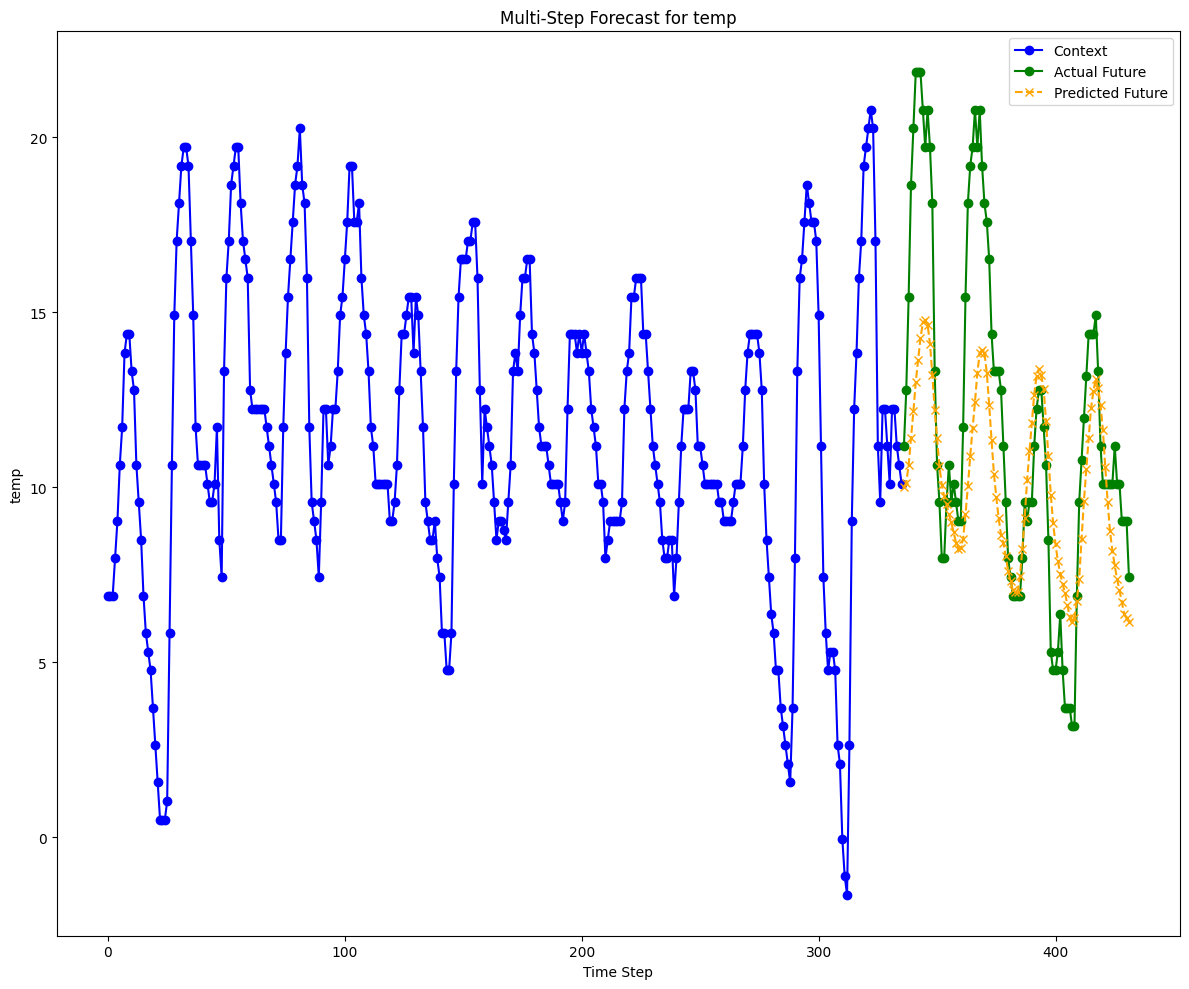

In [ ]:
plt.figure(figsize=(12, 10))

for var_idx, col in enumerate(variable_column):
    plt.subplot(len(variable_column), 1, var_idx + 1)

    # # Extract data for the last sample
    # context = X_test[-1, :, var_idx] * scaler_stats[col]['std'] + scaler_stats[col]['mean']
    # actual_future = y_test_actual[-1, :, var_idx] #actual and pred denormalized in prev cell
    # First sample of DENW094 station to compare with PatchTST
    X_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    context=X_test_full[X_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1
    # First sample of DENW094 station to compare with PatchTST
    y_first_idx = np.flatnonzero(X_test_full[:, 0, 0] == 'DENW094')[0]
    actual_future=y_test_full[y_first_idx, :, var_idx+1] * scaler_stats[col]['std'] + scaler_stats[col]['mean'] # First column is station code hence adding 1

    predicted_future = lstm_predictions[-1, :, var_idx] #actual and pred denormalized in prev cell

    # Plot context
    plt.plot(range(context_window), context, label="Context", color="blue", marker="o")

    # Plot actual future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        actual_future,
        label="Actual Future",
        color="green",
        marker="o"
    )

    # Plot predicted future
    plt.plot(
        range(context_window, context_window + prediction_horizon),
        predicted_future,
        label="Predicted Future",
        color="orange",
        linestyle="--",
        marker="x"
    )

    plt.title(f"Multi-Step Forecast for {col}")
    plt.xlabel("Time Step")
    plt.ylabel(col)
    plt.legend()

plt.tight_layout()
plt.show()


Then save the results for our custom plotting function.